In [47]:
#%% neo python (one time install)
#! pip install neo
#%% allen brain institute (one time install)
#pip install git+git://github.com/BlueBrain/eFEL

In [137]:
#%%
from neo import io
import numpy as np
import matplotlib.pyplot as plt
import efel
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages
import pyabf
import seaborn as sns
import os.path
import chart_studio.plotly as py
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go

In [138]:
#%% you can see all the features here
# efel.getFeatureNames()

In [158]:
#%% define the path to long suares
# a trace with a test pulse
path = r'C:\Users\shossein\Desktop\New folder\2020\December\14.12.2020'
save_path = r'C:\Users\shossein\Desktop\New folder\2020\December\14.12.2020\Cell_7\Intrinsic_properties' # DEFINE the file directory for saving

#Long-Square I-V traces
file_nameL = path + '\THC_1261_PFC_Cronos_14122020_0041.abf'
abfL = pyabf.ABF(path + '\THC_1261_PFC_Cronos_14122020_0041.abf')
#Take alook at the data
print(abfL)


# ramp I-V traces
abfR = pyabf.ABF(path + '\THC_1261_PFC_Cronos_14122020_0042.abf')

print(abfR)

# path = 'THC_1154_CeA_Cronos_07122020_0022.abf'



ABF (version 2.9.0.0) with 2 channels (mV, mV), sampled at 20.0 kHz, containing 16 sweeps, having no tags, with a total length of 0.26 minutes, recorded with protocol "CC_longSquare_IV_ABA".
ABF (version 2.9.0.0) with 2 channels (mV, mV), sampled at 20.0 kHz, containing 3 sweeps, having no tags, with a total length of 0.80 minutes, recorded with protocol "CC_ramp_AllenBrainAtlas".


In [140]:
#%% loading the data
r = io.AxonIO(filename=file_nameL)
bl = r.read_block(lazy=False)

data = []
for trace in bl.segments:
    
    # The voltage is already in mV 
    voltage = np.array(trace.analogsignals[0]).flatten()
    
    # The current looks like it is in pA, let's put it in nA
    current = 1e-3 * np.array(trace.analogsignals[1]).flatten()
    
    # Get the sampling frequency from the file and create the time series in ms
    dt = 1. / int(trace.analogsignals[0].sampling_rate)
    time = 1e3 * dt * np.asarray([i for i in range(len(voltage))])
    
    data.append({'v': voltage,
                 'i': current,
                 't': time})


In [141]:
#%%
# from ipfx.feature_extractor import SpikeFeatureExtractor

# # Assumes that you have variables t (time stamps), v (membrane voltage) and i (stimulus current waveform) loaded from your ABF files

# # Extract information about the spikes
# ext = SpikeFeatureExtractor()
# for idx,trace in enumerate(data[10:]):
#     results = ext.process(t=trace['t'], v=trace['v'], i=trace['i'])
    
#     # Plot the results, showing two features of the detected spikes
#     plt.plot(trace['t'], trace['v'])
#     plt.plot(results["peak_t"], results["peak_v"], 'r.')
#     plt.plot(results["threshold_t"], results["threshold_v"], 'k.')
#     plt.show()

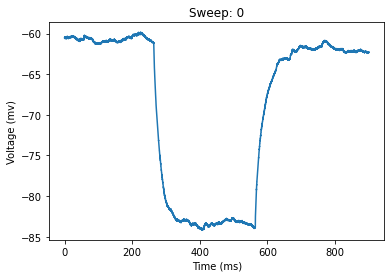

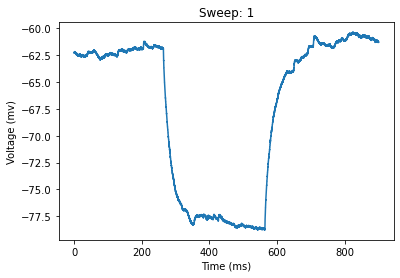

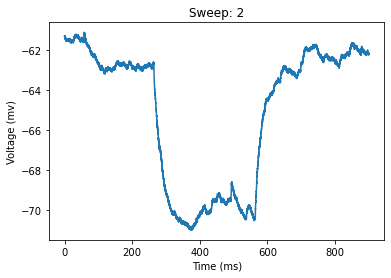

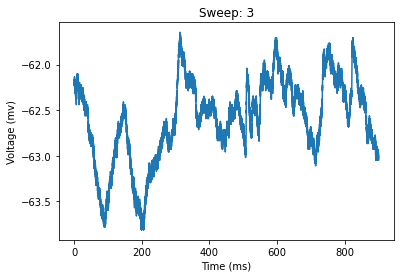

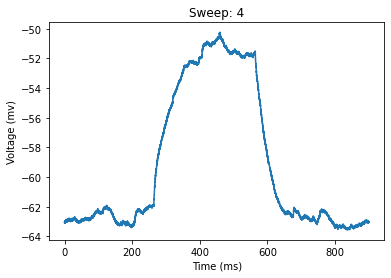

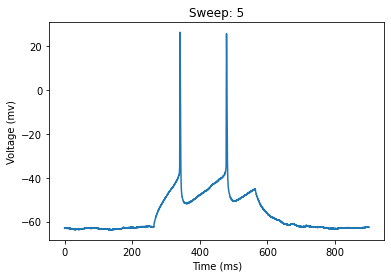

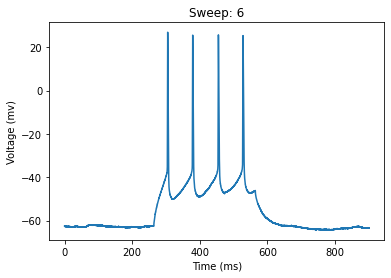

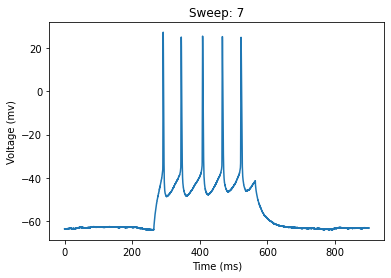

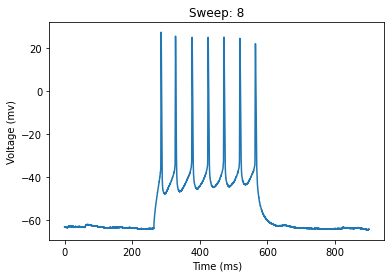

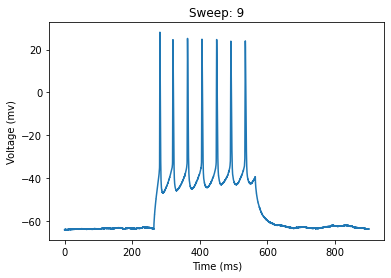

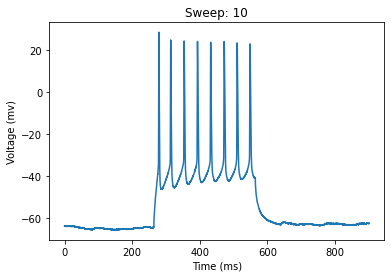

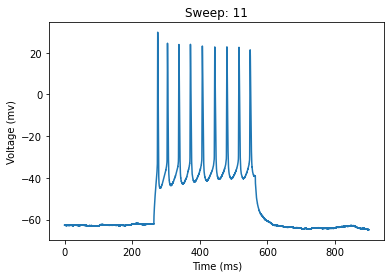

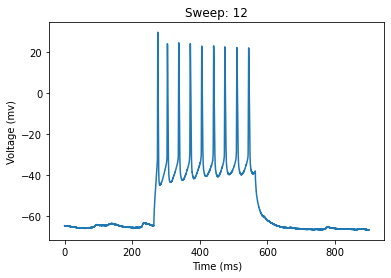

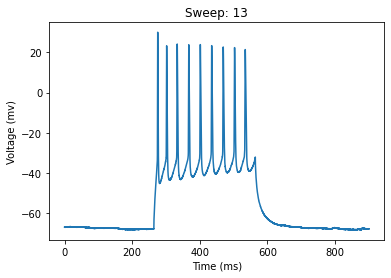

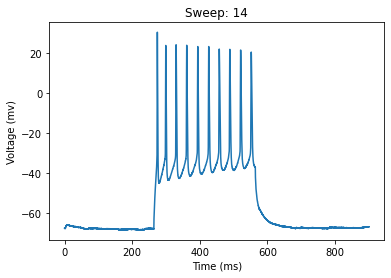

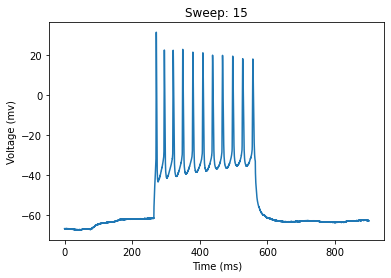

In [142]:
#%% LOOKING AT THE DATA
# all traces
efel.setThreshold(-20.)
efel.setIntSetting("strict_stiminterval", True)

fel_vals = []

# Looking at the data, we see that the beginning and the end of the steps are at 264 and 564 ms respectively
ton = 264.
toff = 565.

# converting to ms
ton_idx = int(ton / dt / 1e3)
toff_idx = int(toff / dt / 1e3)


for idx,trace in enumerate(data[0:]):

    
    # Let's set the stimulus_current of Efel, just in case we need it later
    current_amplitude = np.median(trace['i'][ton_idx:toff_idx])
    efel.setDoubleSetting('stimulus_current', current_amplitude)
    
     # Get the e-features
    interesting_efeatures = ['AP_amplitude', 'AP_begin_voltage', 'AHP_depth', 'AP_width', 
                             'AP_fall_time','AP_rise_time', 'Spikecount', 'spike_width2', 
                             'AP_width', 'spike_half_width', 'peak_time', 'peak_voltage', 
                             'AP_begin_time', 'AP_begin_width', 'mean_frequency','voltage_base',
                             'AHP_time_from_peak', 'AP_height', 'AHP_depth_abs',
                             'AHP_time_from_peak','voltage_deflection','AHP_time_from_peak']
    efel_trace = [{'T': trace['t'],
                   'V': trace['v'],
                   'stim_start': [ton],
                   'stim_end': [toff]}]
    fel_val = efel.getFeatureValues(efel_trace,
                                     interesting_efeatures,
                                     raise_warnings=False)[0]
    # fel_val_array = np.array(list(fel_val. items()))


    fel_vals.append(fel_val)
    
    plt.plot(trace['t'], trace['v'])
    plt.title('Sweep: %d' %idx)

    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mv)')


    plt.show()

<ipython-input-143-d89ecece71ad>:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



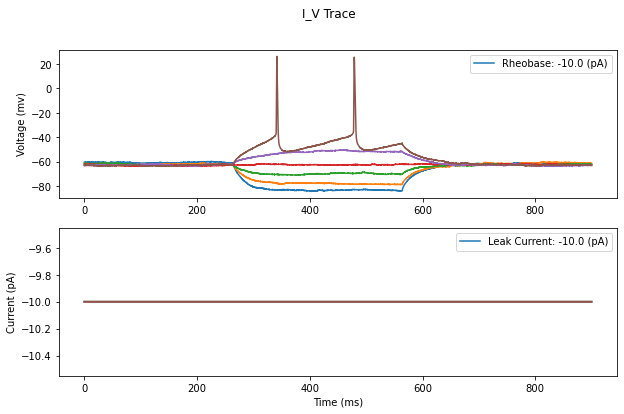

In [143]:
#%%
# reohbase (the first current step at duration infinity(~~ 300 ms) which causes the neuron to fire)
# setting for efel
efel.setThreshold(-20.)
efel.setIntSetting("strict_stiminterval", True)
efel.setDoubleSetting('interp_step', 0.01)


# Looking at the data, we see that the beginning and the end of the steps are at 264 and 564 ms respectively
ton = 264.
toff = 564.
toff_leak = 240.
# path to save the results


# converting to ms
ton_idx = int(ton / dt / 1e3)
toff_idx = int(toff / dt / 1e3)
toff_leak_idx =int(toff_leak / dt / 1e3)
rheobase_sweep = 6 #DEFINE THE REOHBASE SWEEP



leak_current = np.mean(trace['i'][:toff_leak_idx])*1e3 # pA
Rheobase = np.mean(trace['i'][ton_idx:toff_idx])*1e3 # pA
fig, ax = plt.subplots(2, 1, figsize=(10, 6))



for idx,trace in enumerate(data[0:rheobase_sweep]): #DEFINE THE REOHBASE SWEEP

    
    # Let's set the stimulus_current of Efel, just in case we need it later
    current_amplitude = np.median(trace['i'][ton_idx:toff_idx])
    efel.setDoubleSetting('stimulus_current', current_amplitude)

    ax[0].plot(trace['t'], trace['v'])

    ax[0].set_ylabel('Voltage (mv)')
    ax[0].legend(['Rheobase: %5.1f (pA)'  % Rheobase])
    
    
    ax[1].plot(trace['t'], trace['i']*1e3) # convert current to pA
    
    ax[1].set_xlabel('Time (ms)')
    ax[1].set_ylabel('Current (pA)')

    fig.suptitle('I_V Trace')
    # ax[0].legend(['Rheobase: %5.1f (pA)'  % Rheobase])
    ax[1].legend(['Leak Current: %5.1f (pA)'  % leak_current])

    fig.savefig(os.path.join(save_path ,"I_V_Rheobase.svg"))
    fig.savefig(os.path.join(save_path ,"I_V_Rheobase.pdf"))

    
fig.show()




In [144]:
#%% Determin the spiking threshold in volatge
#  C is the spiking threshold
def func_exp_1(x, a, b, c):
    return a * np.exp(-x / b) + c

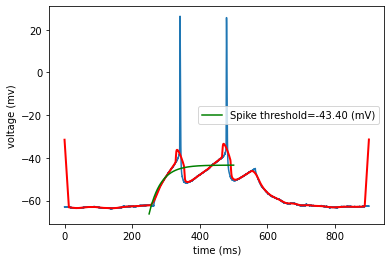

In [145]:
#%% Determin the spiking threshold


for idx,trace in enumerate(data[5:6]): # First spiking sweep


    efel_trace = [{'T': trace['t'],
                   'V': trace['v'],
                   'stim_start': [ton],
                   'stim_end': [toff]}]

    # plt.plot(trace['t'], trace['v'])
    
    
sr =abfL.dataRate    # SAMPLING rate
start = np.int(0.250 * sr) # fit start
end = np.int(0.500  * sr) # ADJUST THE NUMBER
smooth_win = 500
# smooth the data using convolution
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, 'same')
    return y_smooth
# trace= [smooth(trace[:part],30) : trace[part:]]
plt.plot(trace['t'], trace['v'])
plt.plot(trace['t'], smooth(trace['v'],smooth_win), 'r-', lw=2)

# the initial parameters
min_peak_value = np.min((smooth(trace['v'],smooth_win))[start:end])
min_peak = np.where((smooth(trace['v'],smooth_win)) == min_peak_value)[0][0]
p0 = [np.abs(min_peak_value), np.abs(trace['t'][min_peak]), 0.00001]

popt, pcov = curve_fit(func_exp_1, trace['t'][start:end], (smooth(trace['v'],smooth_win))[start:end], p0, maxfev = 10000)
    
    
plt.plot(trace['t'][start:end], func_exp_1(trace['t'][start:end], *popt), 'g-',
    label='Spike threshold=%5.2f (mV)' % (popt[2]))
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('voltage (mv)')
plt.savefig(os.path.join(save_path ,"spike_threshold_smoothed.svg")) 
plt.savefig(os.path.join(save_path ,"spike_threshold_smoothed.pdf"))
reset_threshold_smoothed = popt[2]


In [146]:
#%% changing window size parameters
efel.setDoubleSetting('interp_step', 0.1)

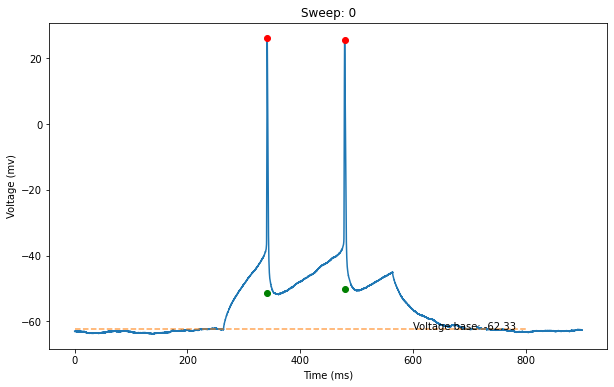

<Figure size 432x288 with 0 Axes>

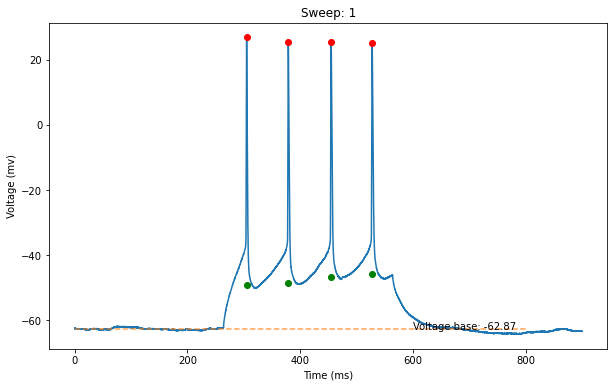

<Figure size 432x288 with 0 Axes>

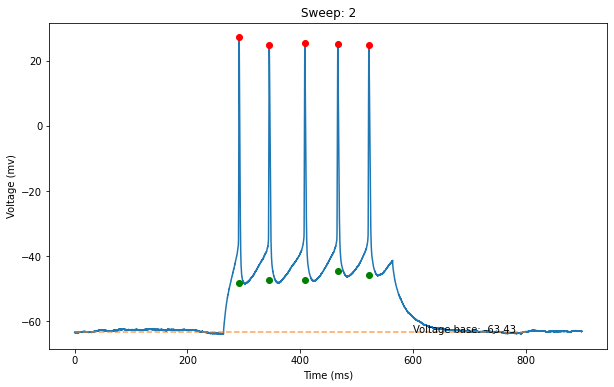

<Figure size 432x288 with 0 Axes>

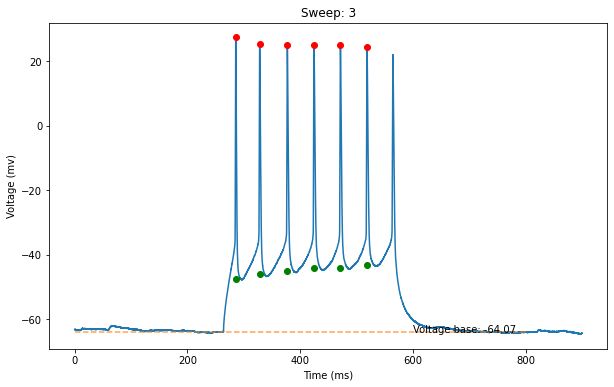

<Figure size 432x288 with 0 Axes>

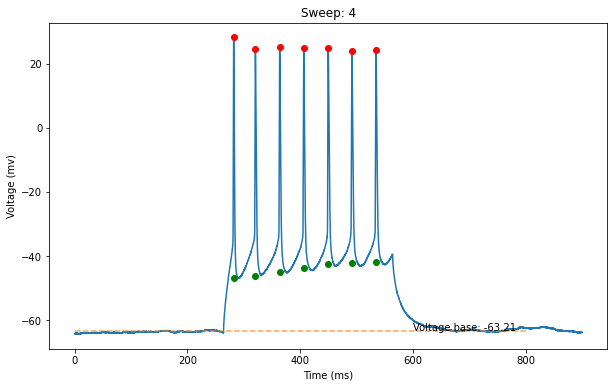

<Figure size 432x288 with 0 Axes>

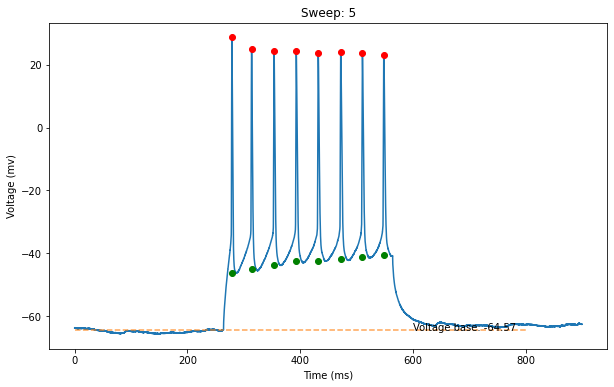

<Figure size 432x288 with 0 Axes>

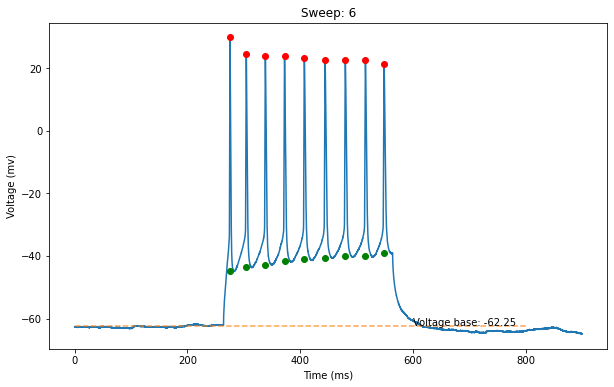

<Figure size 432x288 with 0 Axes>

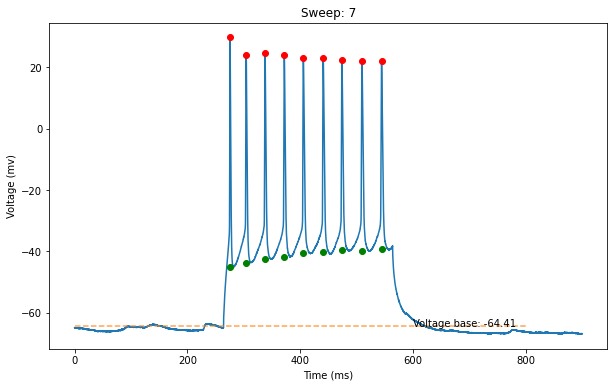

<Figure size 432x288 with 0 Axes>

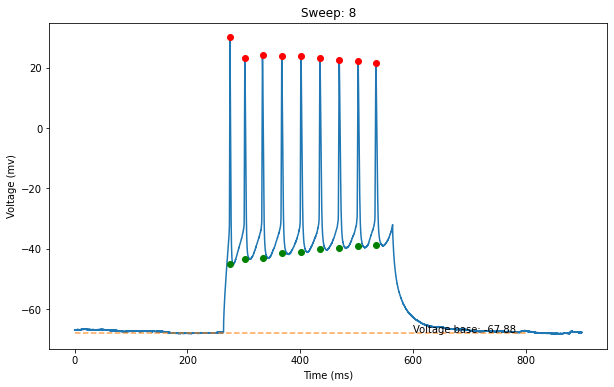

<Figure size 432x288 with 0 Axes>

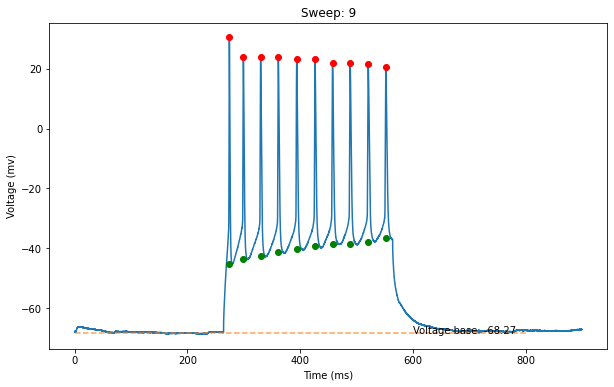

<Figure size 432x288 with 0 Axes>

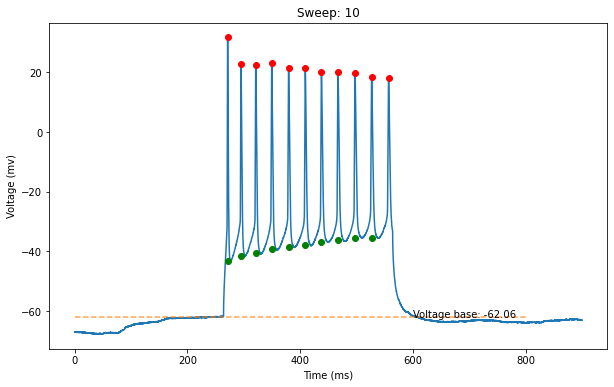

<Figure size 432x288 with 0 Axes>

In [147]:
#%% AP params for all traces
efel.setThreshold(-20.)
efel.setIntSetting("strict_stiminterval", True)


# Looking at the data, we see that the beginning and the end of the steps are at 264 and 564 ms respectively
ton = 246.
toff = 564.
ton_idx = int(ton / dt / 1e3)
toff_idx = int(toff / dt / 1e3)

pdf_pages = PdfPages(os.path.join(save_path ,'APs.pdf'))

reset_threshold = [] #in (mV)
AP_width = [] # in (ms)
AHP = [] # in (mV)
AHP_slow = [] # in (mV)
AP_fall = [] # in (ms)
AP_rise = [] # in (ms)
ISI_CVV = []
adaptation_indexx = []
FWHM =[] # in (ms)


##### YOU HAVE TO KNOW from which trace we want to demonstrate
for idx,trace in enumerate(data[5:]):
    
    # Let's set the stimulus_current of Efel, just in case we need it later
    current_amplitude = np.median(trace['i'][ton_idx:toff_idx])
    efel.setDoubleSetting('stimulus_current', current_amplitude)
    
    # Get the e-features
    interesting_efeatures = ['peak_time','AP_amplitude', 'peak_voltage', 'AP_begin_time', 'AP_begin_width', 
                             'AP_begin_voltage', 'mean_frequency','ISI_CV','voltage_base','AHP_depth', 'AHP_time_from_peak', 
                             'AP_width', 'AP_height', 'AHP_depth_abs','AHP_time_from_peak','AP_fall_time',
                             'adaptation_index', 'AHP_depth_abs_slow','AP_rise_time']
    efel_trace = [{'T': trace['t'],
                   'V': trace['v'],
                   'stim_start': [ton],
                   'stim_end': [toff]}]
    fel_val = efel.getFeatureValues(efel_trace,
                                     interesting_efeatures,
                                     raise_warnings=False)

    


    fig = plt.figure(figsize=(10, 6))
    plt.plot(trace['t'], trace['v'])
    try:
        for time in range (len(fel_val[0]['peak_time'])): 
            plt.plot(fel_val[0]['peak_time'][time], fel_val[0]['AP_height'][time], 'or')
          # plt.show()


        for time in range (len(fel_val[0]['AHP_depth_abs'])): 
            plt.plot(fel_val[0]['peak_time'][time], fel_val[0]['AHP_depth_abs'][time], 'og')


        for peak in fel_val[0]['voltage_base']:
            plt.plot([0,800], [peak, peak], ls='--', alpha=0.7, c='C1') # choose the line coordinates for voltage base
            plt.title('Sweep: %d' %idx)
            plt.xlabel('Time (ms)')
            plt.ylabel('Voltage (mv)')

            plt.annotate('Voltage base: %.2f' %(fel_val[0]['voltage_base'][0]), [600,fel_val[0]['voltage_base'][0]] )
            plt.show()
            plt.savefig(os.path.join(save_path ,"AP_lastSweep.svg")) 
            pdf_pages.savefig(fig)
            # plt.savefig("/content/drive/My Drive/PFC_LC_1/21.05.2020/sEPSCs/" + "AP.svg") 
            # plt.savefig("/content/drive/My Drive/PFC_LC_1/21.05.2020/sEPSCs/Sweep" + str(idx) + "I_V_traces_params.png",) # saving individual file

            reset_thresholdd = (fel_val[0]['AP_begin_voltage'][0]) #in (mV)
            reset_threshold.append(reset_thresholdd)
            if (fel_val[0]['AP_begin_width']) is not None:
                AP_widthh = (fel_val[0]['AP_begin_width'][0]) # in (ms)
                AP_width.append(AP_widthh)
            else:
                pass
            if (fel_val[0]['AP_width']) is not None:
                FWHMM = (fel_val[0]['AP_width'][0]) # in (ms)
                FWHM.append(FWHMM)
            else:
                pass
            if (fel_val[0]['AHP_depth']) is not None:
                AHPh = (fel_val[0]['AHP_depth'][0]) # in (mV)
                AHP.append(AHPh)
            else:
                pass
            if (fel_val[0]['AHP_depth_abs_slow']) is not None:
                AHP_sloww = (fel_val[0]['AHP_depth_abs_slow'][0]) -fel_val[0]['voltage_base'][0] # in (mV)
                AHP_slow.append(AHP_sloww)
            else:
                pass

            if fel_val[0]['AP_fall_time'] is not None:
                AP_falll = (fel_val[0]['AP_fall_time'][0]) # in (ms)
                AP_fall.append(AP_falll)
            else:
                pass
            if fel_val[0]['AP_rise_time'] is not None:
                AP_risee = (fel_val[0]['AP_rise_time'][0]) # in (ms)
                AP_rise.append(AP_risee)
            else:
                pass
            if fel_val[0]['ISI_CV'] is not None:
                ISI_CVVv = (fel_val[0]['ISI_CV'])
                ISI_CVV.append(ISI_CVVv)
            else:
                pass
            if fel_val[0]['adaptation_index'] is not None:
                adaptation_indexxx = (fel_val[0]['adaptation_index']) #The adaptation index is zero for a constant firing rate and bigger than zero for a decreasing firing rate
                adaptation_indexx.append(adaptation_indexxx)
            else:
                pass
            # print(fel_val[0]['AP_begin_width'][1])
    except:
        pass
pdf_pages.close()



reset_threshold1 = reset_threshold[0] #in (mV)
AP_width1 = AP_width[0] # in (ms)
AHP1 = AHP[0] # in (mV)
AHP_slow1 = AHP_slow[0] # in (mV)
AP_fall1 = AP_fall[0] # in (ms)
AP_rise1 = AP_rise[0] # in (ms)
ISI_CVV1 = ISI_CVV[0]
adaptation_indexx1 = adaptation_indexx[0][0]
FWHM1 =FWHM[0]# in (ms)


<Figure size 1440x576 with 0 Axes>

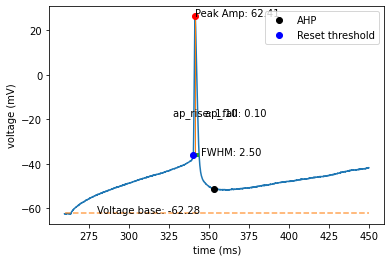

In [149]:
#%% Single AP
# looking at one single example //// Define your sweep number
trace_num = 5  #### CHOOSE YOUR SWEEP NUMBER after Rheobase
Sweep_selected = fel_vals[trace_num]
# Define your window for a single AP
ton = 260.
toff = 450.
ton_idx = int(ton / dt / 1e3)
toff_idx = int(toff / dt / 1e3)



plt.figure(figsize=(20,8))


ap_rise = Sweep_selected['AP_rise_time'][0]
ap_fall = Sweep_selected['AP_fall_time'][0]
ahp_time_from_peak = Sweep_selected['AHP_time_from_peak'][0]
reset_threshold_ap = Sweep_selected['AP_begin_voltage'][0] #in (mV)
peak_time = Sweep_selected['peak_time'][0]
peak_voltage = Sweep_selected['peak_voltage'][0]
peak_amplitude = Sweep_selected['AP_amplitude'][0]
ap_begin_time = Sweep_selected['AP_begin_time'][0]
ap_width = Sweep_selected['AP_width'][0]
ap_begin_voltage = Sweep_selected['AP_begin_voltage'][0]
ap_height = Sweep_selected['AP_height'][0]

voltage_base = Sweep_selected['voltage_base'][0]
ap_amplitude = Sweep_selected['AP_amplitude'][0]
ahp_depth_abs = Sweep_selected['AHP_depth_abs'][0]

# time_spike_indices = np.where((time > 900) & (time < 930))
# time_spike = time[time_spike_indices]
# voltage_spike = voltage[time_spike_indices]

fig3, ax3 = plt.subplots(1)
#plot the ap
for trace in (data[trace_num:trace_num+1]):
    
    # Let's set the stimulus_current of Efel, just in case we need it later
    current_amplitude = np.median(trace['i'][ton_idx:toff_idx])
    efel.setDoubleSetting('stimulus_current', current_amplitude)
    

    efel_trace = [{'T': trace['t'],
                   'V': trace['v'],
                   'stim_start': [ton],
                   'stim_end': [toff]}]

plt.plot(trace['t'][ton_idx:toff_idx], trace['v'][ton_idx:toff_idx])







# ax3.plot(trace['t'][ton_idx:toff_idx], trace['v'][ton_idx:toff_idx])
#plot the ap amplitude AND HALF WIDTH
ax3.plot([peak_time, peak_time], [peak_voltage, peak_voltage - peak_amplitude], linewidth=1)
ax3.plot([ap_begin_time, ap_begin_time + ap_width], 
         [ap_begin_voltage, ap_begin_voltage], linewidth=4)

ax3.set_xlabel('time (ms)')
ax3.set_ylabel('voltage (mV)');


plt.plot([ton,toff], [voltage_base, voltage_base], ls='--', alpha=0.7, c='C1') # choose the line coordinates for voltage base
plt.plot(peak_time, ap_height, 'or')
plt.plot(peak_time+ahp_time_from_peak, ahp_depth_abs, 'ok', label='AHP') # AFTER HYPERPOLARIZATION AMPLITUDE
plt.plot(ap_begin_time, reset_threshold_ap, 'ob', label='Reset threshold') # reset_threshold_ap
# plt.plot(second_ap_begin_time - second_ap_width, second_ap_begin_voltage, 'oy') # spike threshold
plt.annotate('Voltage base: %.2f' %(voltage_base), [280,voltage_base])
plt.annotate('Peak Amp: %.2f' %(ap_amplitude), [peak_time,ap_height])
plt.annotate('FWHM: %.2f' %(ap_width), [(ap_begin_time + 2*ap_width),ap_begin_voltage])
plt.annotate('ap_rise: %.2f' %(ap_rise), [(ap_begin_time - 5*ap_width),ap_begin_voltage - ap_begin_voltage/2 ])
plt.annotate('ap_fall: %.2f' %(ap_fall), [(ap_begin_time + 3*ap_width),ap_begin_voltage - ap_begin_voltage/2 ])
plt.legend()
plt.savefig(os.path.join(save_path ,'Single_AP_parameters.pdf'))
plt.savefig(os.path.join(save_path ,'Single_AP_parameters.svg'))



In [150]:
#%% F_I CURVE////
stim_lin= 0.3 # the duration of the stimulus in seconds
firing_rates = []

for i in range (len(fel_vals)):
    firing_rate = fel_vals[i]['Spikecount'][0] / stim_lin
    firing_rates.append(firing_rate)

In [151]:
#%%
# m is the slope or the F_I Slope (Hz/nA); C is the itercept
def func(x,m,b):
    return np.multiply(m,x)+b

In [152]:
#%% Get the current steps in current clamp protocol
# 10% OF Of THE TRACE (get these start and end valuse from pClamp)
start = np.int(0.550 * sr) 
end = np.int(0.564  * sr)
initial = np.int(0.200  * sr) # baseline duration

current_step=[]
for i in range (abfL.sweepCount):
   abfL.setSweep(sweepNumber=i, channel=1) # set the baseline based on above figure # the current channel
   a = np.median(abfL.sweepY[start:end]) - np.median(abfL.sweepY[0:initial])
   current_step.append(a)
print(current_step)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [153]:
current_step=[-76.293945, -50.65918, -25.024414, 0.0, 25.634766, 51.26953, 76.293945, 101.92871, 127.56348, 152.58789, 177.6123, 203.24707, 228.88184, 253.90625, 280.15137, 305.17578]

In [154]:
#%% F_I CURVE////
# coosing the hyperpolarization traces
# decorate the plot
start_trace = 5

fig = px.scatter(x = current_step,y = firing_rates, labels={'x':'Spikes Frequency (Hz)', 'y':'Current (pA)'}, title="F_I Curve")

popt, pcov = curve_fit(func, current_step[start_trace:], firing_rates[start_trace:])
popt
fig.add_trace(go.Scatter(x = current_step[start_trace:], y = func(current_step[start_trace:], *popt), mode='lines',
    name='F_I Slope (gain)=%5.3f (HZ/nA)' % (popt[0] * 1e3),
    marker=dict(
        color='rgb(255, 0, 0)')))
fig.show()
fig.write_image(os.path.join(save_path , 'F_I_Curve.pdf'))
fig.write_image(os.path.join(save_path , 'F_I_Curve.svg'))

F_I_Slope = popt[0] *1e3 # this is the gain function or the neuronal excitability




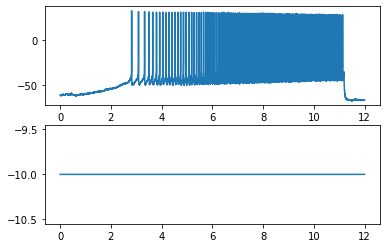

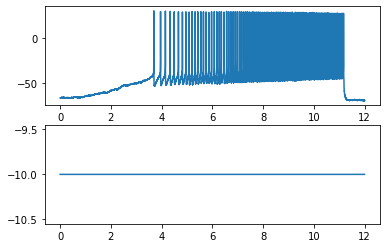

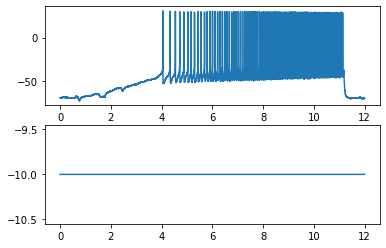

In [155]:
#%%looking at the data of Ramp
for i in range (0,3): # the number of sweeps in hyperpolarization steps
    fig, ax = plt.subplots(2)
    abfR.setSweep(sweepNumber=i, channel=0)
    ax[0].plot(abfR.sweepX, abfR.sweepY, label="Channel 0")
    abfR.setSweep(sweepNumber=i, channel=1)
    ax[1].plot(abfR.sweepX, abfR.sweepY, label="Channel 1")

In [157]:
#%% current step for ramp trace

#Get the current steps in current clamp protocol
sr = abfR.dataRate    # SAMPLING rate

start = np.int(0.001 * sr) 
duration = 11000 # the duration of your trace

current_step=[]
# for i in range (abf.sweepCount):
for i in range(1,duration,1):
   # abf.setSweep(sweepNumber=i, channel=1) # set the baseline based on above figure # the current channel
   abfR.setSweep(sweepNumber=0,channel=1)
   a = np.median(abfR.sweepY[start*i:start*(i+1)])
   current_step.append(a)

# current_step = (current_step-current_step[0]).tolist() # convert pA to nA
# print(current_step)

In [159]:
#%% voltage step for ramp trace

# 10% OF OF THE TRACE (gwt these start and end valuse from pClamp)
start = np.int(0.001 * sr)  


voltage_step=[]
# for i in range (abf.sweepCount):
for i in range(1,duration,1):
   # abf.setSweep(sweepNumber=i, channel=1) # set the baseline based on above figure # the current channel
   abfR.setSweep(sweepNumber=0,channel=0)
   a = np.median(abfR.sweepY[start*i:start*(i+1)])
   voltage_step.append(a)

# current_step = (current_step-current_step[0]).tolist() # convert pA to nA
# print(current_step)


-38.55896


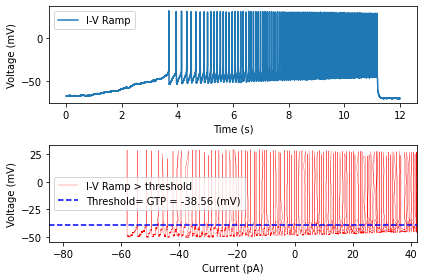

In [160]:
#%% Finding the turning point or the threshold
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
# generate some toy data
# n = 600
t = np.array(current_step)
y = np.array(voltage_step)

# # get the gradient
dy = np.gradient(y)

# # search gradient for first occurrence of thresh value:
thresh = 1 # define the threshold

y_filtered = savgol_filter(y, 11, 3)
dy_f = np.gradient(y_filtered)
idx_thresh = np.argmax(dy_f > thresh)
turning_point_ramp= y[idx_thresh]
print(turning_point_ramp)

fig, ax = plt.subplots(2)

abfR.setSweep(sweepNumber=1, channel=0)
ax[0].plot(abfR.sweepX, abfR.sweepY,  label = 'I-V Ramp')
ax[0].set(xlabel="Time (s)", ylabel="Voltage (mV)")
# ax[0].set_ylabel('Voltage (mV)')
ax[0].legend()
# plt.plot(t, dy_f, 'g', label='gradient turning point = %5.2f (mV)' % (turning_point_ramp),linewidth=0.3)
ax[1].plot(t[idx_thresh:], y[idx_thresh:], 'r', label='I-V Ramp > threshold', linewidth=0.3)
ax[1].set_xlim([t[0], t[-1]])
ax[1].axhline(y=turning_point_ramp, color='b', linestyle='--', label= 'Threshold= GTP = %5.2f (mV)' % (turning_point_ramp))
ax[1].set_xlabel('Current (pA)')
ax[1].set_ylabel('Voltage (mV)')
ax[1].legend()
fig.tight_layout()

plt.savefig(os.path.join(save_path ,'I_V_Curve_ramp.svg'))
plt.savefig(os.path.join(save_path ,'I_V_Curve_ramp.pdf'))




In [161]:
#%% Exporting data to Excell for analysis
writer = pd.ExcelWriter(os.path.join(save_path, 'Active_electrical_properties_41_42.xlsx'))

pd.DataFrame({'leak_current (pA)': 
              [leak_current]}).to_excel(writer,sheet_name = 
                                               'LongSquare', startcol=0,index=False)
pd.DataFrame({'Rheobase (pA)': 
              [Rheobase]}).to_excel(writer,sheet_name = 
                                                'LongSquare', startcol=1, index=False)
pd.DataFrame({'reset_threshold_smoothed (mv)': 
              [reset_threshold_smoothed]}).to_excel(writer,sheet_name = 
                                                'LongSquare', startcol=2, index=False)
pd.DataFrame({'reset_threshold (mv)': 
              [reset_threshold1]}).to_excel(writer,sheet_name = 
                                                'LongSquare', startcol=3, index=False)
pd.DataFrame({'F_I_Slope Hz/nA)': 
              [F_I_Slope]}).to_excel(writer,sheet_name = 
                                                'LongSquare', startcol=4, index=False)

                                                  
                                                  
pd.DataFrame({'AP_width (ms)': 
              [AP_width1]}).to_excel(writer,sheet_name = 
                                                'AP', startcol=0, index=False) 
pd.DataFrame({'AHP (mV)': 
              [AHP1]}).to_excel(writer,sheet_name = 
                                                'AP', startcol=1, index=False) 
pd.DataFrame({'AHP_slow (mV)': 
              [AHP_slow1]}).to_excel(writer,sheet_name = 
                                                'AP', startcol=2, index=False) 
pd.DataFrame({'AP_fall (ms)': 
              [AP_fall1]}).to_excel(writer,sheet_name = 
                                                'AP', startcol=3, index=False) 
pd.DataFrame({'AP_rise (mms)': 
              [AP_rise1]}).to_excel(writer,sheet_name = 
                                                'AP', startcol=4, index=False)   
pd.DataFrame({'ISI_CVV': 
              [ISI_CVV1]}).to_excel(writer,sheet_name = 
                                                'AP', startcol=5, index=False) 
pd.DataFrame({'adaptation_indexx': 
              [adaptation_indexx1]}).to_excel(writer,sheet_name = 
                                                'AP', startcol=6, index=False) 
pd.DataFrame({'FWHM (ms)': 
              [FWHM1]}).to_excel(writer,sheet_name = 
                                                'AP', startcol=7, index=False) 
                                                  
                                                
                                                

pd.DataFrame({'turning_point_ramp (mV)': 
              [turning_point_ramp]}).to_excel(writer,sheet_name = 
                                               'Ramp', startcol=0,index=False)
 
                                        
writer.save()
